In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [26]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "cars.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "abdulrahmankhaled1/1983-2020-used-cars",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

C:\Users\yalts\AppData\Local\Temp\ipykernel_35764\3538958269.py:8: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


First 5 records:                            name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5

In [27]:

# # Load the dataset
# file_path = 'cars.csv'
# df = pd.read_csv(file_path)

# Initial data inspection
print("Initial DataFrame shape:", df.shape)
print(df.head())
print(df.info())

# Drop rows with missing values
df_clean = df.dropna()
print("Cleaned DataFrame shape:", df_clean.shape)

# Remove extreme outliers based on Price using z-score filtering
df_clean = df_clean[(np.abs(stats.zscore(df_clean['selling_price'])) < 3)]
print("DataFrame shape after removing outliers:", df_clean.shape)


Initial DataFrame shape: (8128, 13)
                           name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            

Mean Squared Error: 32289822761.94
R^2 Score: 0.81

5 Worst Predictions:
      Actual      Predicted         Error
0  1920000.0  436879.347114  1.483121e+06
1  1925000.0  398888.889533  1.526111e+06
2  2000000.0  355219.196703  1.644781e+06
3  2700000.0  356769.862565  2.343230e+06
4  2850000.0  476546.705462  2.373453e+06


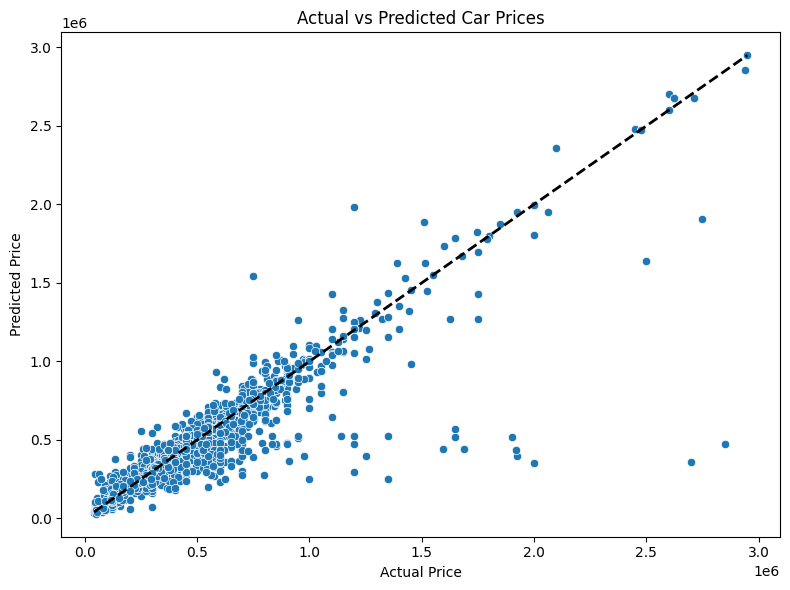


Model Coefficients:
                                       Feature   Coefficient
0                                         year  3.417804e-01
1                                    km_driven -1.655296e-02
2       name_Ambassador Classic 2000 DSZ AC PS  6.667914e-03
3         name_Ambassador Grand 1500 DSZ BSIII -5.289489e-03
4         name_Ambassador Grand 2000 DSZ PW CL -1.782446e-26
...                                        ...           ...
1954  name_Volkswagen Vento Petrol Highline AT  1.175248e-04
1955    name_Volkswagen Vento Petrol Trendline -1.202980e-03
1956                  name_Volvo S60 D4 SUMMUM  2.570191e-02
1957           name_Volvo V40 Cross Country D3  1.576335e-02
1958                name_Volvo V40 D3 R-Design  1.006010e-01

[1959 rows x 2 columns]


In [28]:

# Encode categorical features
if 'name' in df_clean.columns:
    df_clean = pd.get_dummies(df_clean, columns=['name'], drop_first=True)

# Select features and log-transform the target
y = np.log(df_clean['selling_price'])
features = ['year','km_driven'] + [col for col in df_clean.columns if col.startswith('name')]
X = df_clean[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)#, random_state=42)

# Model training using Ridge regression
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Predictions
log_preds = model.predict(X_test)
y_pred = np.exp(log_preds)
y_test_actual = np.exp(y_test)

# Evaluation
mse = mean_squared_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Find 5 worst predictions
errors = np.abs(y_test_actual - y_pred)
worst_indices = errors.argsort()[-5:]
wrong_preds = pd.DataFrame({
    'Actual': y_test_actual.iloc[worst_indices].values,
    'Predicted': y_pred[worst_indices],
    'Error': errors.iloc[worst_indices].values
})
print("\n5 Worst Predictions:")
print(wrong_preds)

# Plotting predicted vs actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_actual, y=y_pred)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices')
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

# Save model coefficients for interpretation
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
})
print("\nModel Coefficients:")
print(coef_df)

# Save to GitHub-ready format
coef_df.to_csv('model_coefficients.csv', index=False)
wrong_preds.to_csv('worst_predictions.csv', index=False)